# Classification analysis

**Author:** M.G. Baltussen

This notebook performs weight training and plots results for a set of (nonlinear) classification tasks.

**Estimated running time:** 5 minutes

**Generated output:**
```
plots/classification_input.{svg,png} (manuscript figure 2)
plots/classification_single_prediction.{svg,png} (manuscript figure 2)
plots/classification_results.{svg,png} (manuscript figure 2)
```

## Imports

In [6]:
""" System imports """
import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.75, 
rc={
    "axes.linewidth": 0.5,     
    'axes.facecolor':'#eceff4', 
    'axes.edgecolor':'#2e3440',
    'axes.labelcolor':'#2e3440',
    'text.color': '#2e3440',
    'xtick.color': '#2e3440',
    'ytick.color': '#2e3440',
    'font.family': 'Arial',
    'svg.fonttype': 'none',
    })
import colorcet as cc

nord_palette = [
    "#bf616a","#d08770","#ebcb8b","#a3be8c","#b48ead",
    "#8fbcbb","#88c0d0","#81a1c1","#5e81ac",
    "#2e3440","#3b4252","#434c5e","#4c566a",
    "#d8dee9","#e5e9f0","#eceff4",
]

sns.set_palette(nord_palette)

def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)

def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)


## Data loading

In [7]:
""" Load preprocessed data"""

df_all = pd.read_csv("../data/steadystates.csv", index_col=0)

U_chem = df_all[['NaOH', 'Form']].values
X_orig = df_all.drop(columns=['time', 'NaOH', 'Form', 'exp']).values

pad_frac = np.array([-0.05, 0.05])
ranges = np.array([[10, 50], [10, 150]])
pad = pad_frac*np.diff(ranges, axis=1)
extends = ranges + pad
x_extend = extends[0]
y_extend = extends[1]
U = (U_chem - extends[:,0])/(extends[:,1]-extends[:,0])

X = preprocessing.StandardScaler().fit_transform(X_orig)

## Classification task definitions

In [8]:
from collections import OrderedDict

""" Generating training labels from inputs """
y_xor = np.logical_xor(U[:,0] < 0.5, U[:,1] < 0.5)
y_circle = ((U[:,0]-0.5)**2 + (U[:,1]-0.5)**2) < 0.125
y_sin =  U[:,1] > 0.5 + 0.5*np.sin(U[:,0]*np.pi*2/0.8 - np.pi/4)

y_eye = 1*(((U[:,0]-0.5)**2 + (U[:,1]-0.5)**2) < 0.16) - 1*(((U[:,0]-0.5)**2 + (U[:,1]-0.5)**2) < 0.04)
y_dots = 1*(((U[:,0]-0.3)**2 + (U[:,1]-0.3)**2) < 0.05) + 1*(((U[:,0]-0.7)**2 + (U[:,1]-0.7)**2) < 0.05)


def triangle(x, y):
   z_triangle_b1 =  (y < x/3 + 1/3)
   z_triangle_b2 = (x < y/3 + 1/3)
   z_triangle_b3 = (y < -x + 1) 
   z_triangle_1 = -1*np.logical_and(z_triangle_b1, z_triangle_b3)
   z_triangle_2 = 0.0* np.logical_and(z_triangle_b2, ~z_triangle_b1)
   z_triangle_3 = np.logical_and(~z_triangle_b2, ~z_triangle_b3)
   z_triangle = z_triangle_1 + z_triangle_2 + z_triangle_3
   return z_triangle

y_linear = U[:,1] > U[:,0] 
y_and = np.logical_and(U[:,0] > 0.5, U[:,1] > 0.5)
y_or = np.logical_or(U[:,0] > 0.5, U[:,1] > 0.5)
y_triangle = triangle(U[:,0], U[:,1])
y_checker = np.logical_xor((U[:,0] // 0.33333)%2, (U[:,1] // 0.33333)%2)

y_train_linear = OrderedDict(
   Linear= y_linear,
   AND= y_and,
   OR= y_or,
   Triangle = y_triangle,
   Checkers = y_checker,
)

y_train = OrderedDict(
   AND = y_and,
   OR = y_or,
   Linear= y_linear,
   Triangle = y_triangle,
   XOR= y_xor,
   Checkers = y_checker,
   Circle= y_circle,
   Sine= y_sin,
   Concentric = y_eye,
   Dots = y_dots,
)


In [9]:
""" Generating background color-grids """
N_POINTS = 1000
xx = np.linspace(*x_extend, N_POINTS)
yy = np.linspace(*y_extend, N_POINTS)
xs, ys = np.meshgrid(np.linspace(0, 1.0, N_POINTS), np.linspace(0, 1.0, N_POINTS))

z_xor = np.logical_xor(xs < 0.5, ys < 0.5)
z_circle = ((xs-0.5)**2 + (ys-0.5)**2) < 0.125
z_eye = 1*(((xs-0.5)**2 + (ys-0.5)**2) < 0.16) - 1*(((xs-0.5)**2 + (ys-0.5)**2) < 0.04)
z_dots = 1*(((xs-0.3)**2 + (ys-0.3)**2) < 0.05) + 1*(((xs-0.7)**2 + (ys-0.7)**2) < 0.05)
z_sin =  ys > 0.5 + 0.5*np.sin(xs*np.pi*2/0.8 - np.pi/4)


z_linear = ys > xs 
z_and = np.logical_and(xs > 0.5, ys > 0.5)
z_or = np.logical_or(xs > 0.5, ys > 0.5)
z_triangle = triangle(xs, ys)
z_checker = np.logical_xor((xs // 0.33333)%2, (ys // 0.33333)%2)

z_train_linear = OrderedDict(
   Linear= z_linear,
   AND= z_and,
   OR= z_or,
   Triangle = z_triangle,
   Checkers = z_checker,
)

z_train = OrderedDict(
   AND  = z_and,
   OR  = z_or,
   Linear = z_linear,
   Triangle  = z_triangle,
   XOR = z_xor,
   Checkers = z_checker,
   Circle = z_circle,
   Sine = z_sin,
   Concentric  = z_eye,
   Dots  = z_dots,
)


## Plots figure 2a

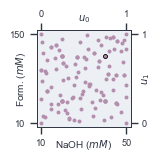

In [10]:
""" Plot full input space with one input highlighted """

SELECTED_TRACES = [11]

titledict = {'fontweight': 'bold'}

fig, axes = plt.subplots(figsize=(1.5, 1.5), constrained_layout=True)

axes.scatter(*U_chem.T, s=8, c='C4', lw=0)
axes.scatter(*U_chem[SELECTED_TRACES].T, s=8, c='C4', ec='black', lw=0.6)

axes.set_xlim(*x_extend)
axes.set_ylim(*y_extend)
axes.set_xticks([10, 50], [10, 50])
axes.set_yticks([10, 150], [10, 150])
axes.set_xlabel(r"NaOH ($mM$)")
axes.set_ylabel(r"Form. ($mM$)")
axes.xaxis.set_label_coords(0.5, -0.1)
axes.yaxis.set_label_coords(-0.1, 0.5)

axy = axes.twiny()
axy.set_xticks([0, 1])
axy.set_xlim(-0.05, 1.05)
axy.set_xlabel(r'$u_0$')

axx = axes.twinx()
axx.set_yticks([0, 1])
axx.set_ylim(-0.05, 1.05)
axx.set_ylabel(r'$u_1$')
axy.xaxis.set_label_coords(0.5, 1.1)
axx.yaxis.set_label_coords(1.1, 0.5)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

save_plot("classification_input")
plt.show()

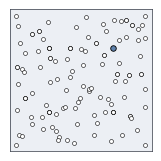

In [11]:
""" Put predicted output for selected input"""

fig, axes = plt.subplots(figsize=(1.5, 1.5), constrained_layout=True)

axes.scatter(*U_chem.T, ec='black', lw=0.4, s=8, c='white')
axes.scatter(*U_chem[SELECTED_TRACES].T, s=16, c='#5E81AC', ec='black', lw=0.6)

axes.set_xticks([])
axes.set_yticks([])
axes.set_xlim(*x_extend)
axes.set_ylim(*y_extend)
save_plot("classification_single_prediction")

## Training and plots figure 2b

In [29]:
model_selection.RepeatedStratifiedKFold(n_splits=132//5, n_repeats=10).split(X,y_train['AND']).__next__()

(array([  0,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 102, 103, 104, 105, 106,
        107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121,
        122, 123, 124, 125, 126, 128, 129, 130, 131]),
 array([  1,   4, 101, 109, 118, 127]))

In [20]:
model_selection.RepeatedFold(n_splits=132//5, n_repeats=10).split(X).__next__()

(array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  97,  98,  99, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131]),
 array([  2,  10,  31,  96, 100, 115]))

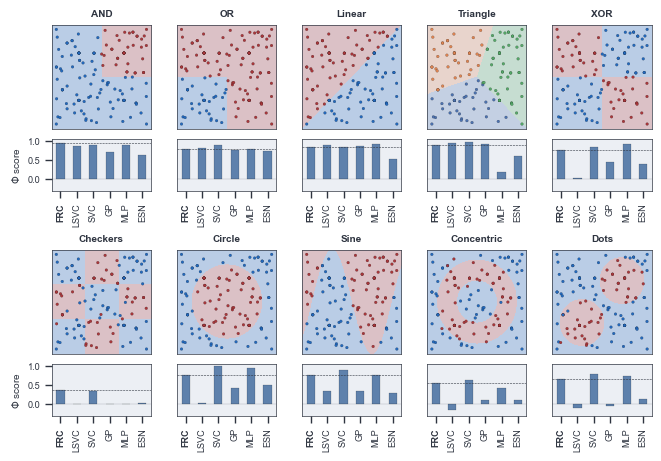

In [31]:
""" Nonlinear classification examples 
Perform training, L5O-CV and plotting 
for every classification task defined above
"""


from sklearn import neighbors, gaussian_process, tree, neural_network


classifiers = {
    # "Ridge": linear_model.RidgeClassifier(alpha=.01),
    "LSVC": svm.LinearSVC(max_iter=10_000, tol=1e-4, dual=True),
    "SVC": svm.SVC(max_iter=10_000, tol=1e-4),
    # "KNN": neighbors.KNeighborsClassifier(5), 
    "GP": gaussian_process.GaussianProcessClassifier(),
    # "DTC": tree.DecisionTreeClassifier(),
    # "LPC": linear_model.Perceptron(),
    "MLP": neural_network.MLPClassifier(max_iter=100_000),
    "ESN": ESNClassifier(regressor=linear_model.Ridge())
}

classifier_labels = ["FRC"] + list(classifiers.keys())
N_classifiers = len(classifiers)
N_tasks = len(z_train)
fig, axes = plt.subplots(4,5, figsize=(6.5, 4.5), 
                         constrained_layout=True,
                         gridspec_kw={
                             'hspace': -0.25,
                            'wspace': 0.2,
                            'height_ratios': [2, 1, 2, 1]
                         }
   )

axes = np.hstack((axes[:2], axes[2:]))

fit_times = OrderedDict()

for i, (k, v) in enumerate(z_train.items()):
    axes[1,i].axhline(0, color='C9', lw=0.1)

    reg = svm.LinearSVC(max_iter=10_000, tol=1e-4, dual=True)
    y = y_train[k]
    scores = model_selection.cross_validate(reg, X, y, scoring = metrics.make_scorer(metrics.matthews_corrcoef),
    cv=model_selection.RepeatedStratifiedKFold(n_splits=132//5, n_repeats=10), n_jobs=10, return_train_score=True)
    
    reg.fit(X, y)
    y_predict = reg.predict(X)
    train_score = reg.score(X, y)


    if (k == 'Triangle') |  (k == 'Cluster'):
        cmap_triangle = mpl.colors.ListedColormap(sns.color_palette("deep", n_colors=3))
        norm = mpl.colors.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], 3)
        axes[0,i].imshow(v, origin='lower', aspect='auto', interpolation='none', extent=(*x_extend, *y_extend), alpha=0.25, 
                            cmap=cmap_triangle, norm=norm)
        axes[0,i].scatter(*U_chem.T, ec='black', lw=0.1, s=4, c=y_predict, cmap=cmap_triangle, norm=norm)
    else:
        axes[0,i].imshow(v, origin='lower', aspect='auto', interpolation='none', extent=(*x_extend, *y_extend), alpha=0.25, cmap=sns.color_palette("vlag", as_cmap=True))
        axes[0,i].scatter(*U_chem.T, ec='black', lw=0.1, s=4, c=y_predict, cmap=sns.color_palette("vlag", as_cmap=True))

    axes[0,i].set_title(k, fontdict=titledict)
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_xlim(*x_extend)
    axes[0,i].set_ylim(*y_extend)

    train_scores = [train_score]
    fit_times[k] = [scores['fit_time'].mean()]
    test_scores = [scores['test_score'].mean()]
    test_scores_std = [scores['test_score'].std()]
    for name, clf in classifiers.items():
        scores = model_selection.cross_validate(clf, U, y, scoring = metrics.make_scorer(metrics.matthews_corrcoef),
        cv=model_selection.RepeatedStratifiedKFold(n_splits=132//5, n_repeats=10), n_jobs=10, 
                                                return_train_score=True)
        clf.fit(U, y)
        y_predict = clf.predict(U)
        train_score = clf.score(U, y.astype(int))
        train_scores.append(train_score)
        fit_times[k].append(scores['fit_time'].mean())
        test_scores.append(scores['test_score'].mean())
        test_scores_std.append(scores['test_score'].std()) 
    axes[1, i].bar(np.arange(0, N_classifiers+1), width=0.5, height=test_scores,
                linewidth=0.1, edgecolor="0.0", ecolor="0.0",
                color='C8',
                label=classifier_labels)
    axes[1, i].set_xticks(np.arange(0,N_classifiers+1))
    axes[1, i].set_xticklabels(classifier_labels, 
                            rotation='vertical', 
                            ha='center'
                            )
    axes[1, i].get_xticklabels()[0].set_weight("bold")

    axes[1, i].set_ylim(-0.3, 1.05)
    axes[1, i].set_yticks([])
    axes[1, i].axhline(test_scores[0], ls='--', lw=0.4, color='C9')

axes[1, 0].set_yticks([0, 0.5, 1.0])
axes[1, 0].set_ylabel(r"$\Phi$ score")
axes[1, 5].set_yticks([0, 0.5, 1.0])
axes[1, 5].set_ylabel(r"$\Phi$ score")

save_plot("classification_results")
plt.show()